<img SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">
    
# Surface water example
   
*D.A. Brakenhoff, Artesia, 2020*

This example notebook shows some how to add surface water defined in a shapefile to a MODFLOW model using the `nlmod` package.
    
    
## Contents<a id='top'></a>

1. [Load data](#1)
2. [Build model](#2)
3. [Add surface water](#3)
    1. [Intersect surface water shape with grid](#3.1)
    2. [Aggregate parameters per model cell](#3.2)
    3. [Build stress period data](#3.3)
    4. [Create RIV package](#3.4)
4. [Write + run model](#4)
5. [Visualize results](#5)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import flopy

import nlmod

In [2]:
print(f'nlmod version: {nlmod.__version__}')

nlmod version: 0.0.1b


## [Load data](#top)<a id='1'></a>
Load shapefile with surface water features. 

In [3]:
sfw = gpd.read_file("../data/shapes/schnhvn_opp_water.shp")

Take a look at the first few rows. For adding surface water features to a MODFLOW model the following attributes must be present:

- **stage**: the water level (in m NAP)
- **botm**: the bottom elevation (in m NAP)
- **c0**: the bottom resistance (in days)

The `stage` and the `botm` columns are present in our dataset. The bottom resistance `c0` is rarely known, and is usually estimated when building the model. We will add our estimate later on.

*__Note__: the NaN's in the dataset indicate that not all parameters are known for each feature. This is not necessarily a problem but this will mean some features will not be converted to model input.*

In [4]:
sfw.head(10)

,unique_id,peilvak_id,zp,wp,stage,botm,geometry
0,None,NL.1.NL94_4,NaN,NaN,NaN,NaN,"POLYGON ((115907.550 437947.371, 115663.397 43..."
1,None,NL.1.NL94_4,NaN,NaN,NaN,NaN,"POLYGON ((115949.685 437910.355, 115944.304 43..."
2,None,NL.1.NL94_4,NaN,NaN,NaN,NaN,"POLYGON ((116220.269 438198.746, 116217.214 43..."
3,None,NL.1.NL94_4,NaN,NaN,NaN,NaN,"POLYGON ((116198.500 438276.160, 116169.501 43..."
4,NL.9.290613,NL.9.OVW067,-0.23,-0.23,-0.230,-0.53,"POLYGON ((115950.663 437697.832, 115949.171 43..."
5,NL.9.290592,NL.9.OVW065,-1.52,-1.57,-1.545,-1.87,"POLYGON ((116118.024 437598.714, 116116.490 43..."
6,NL.9.290628,NL.9.OVW067,-0.23,-0.23,-0.230,-0.53,"POLYGON ((115945.360 437694.440, 115943.680 43..."
7,NL.9.326112,NL.9.OVW067,-0.23,-0.23,-0.230,-0.53,"POLYGON ((115921.088 437673.210, 115923.843 43..."
8,NL.9.326112,NL.9.OVW067,-0.23,-0.23,-0.230,-0.53,"POLYGON ((115906.640 437653.600, 115903.384 43..."
9,None,NL.1.NL94_4,NaN,NaN,NaN,NaN,"POLYGON ((116608.283 438417.517, 116606.433 43..."


Plot the surface water features using the column `peilvak_id` to color the features. 

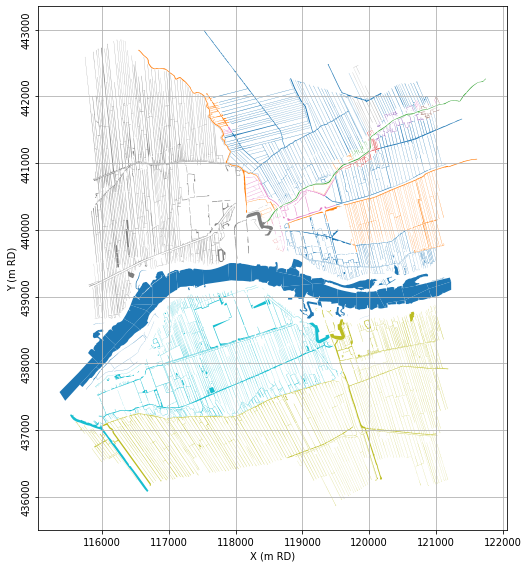

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw.plot(ax=ax, column="peilvak_id")
ax.grid(b=True)
ax.set_xlabel("X (m RD)")
ax.set_ylabel("Y (m RD)")
plt.yticks(rotation=90, va="center")
fig.tight_layout()

Now use `stage` as the column to color the data. Note the missing features caused by the fact that the stage is undefined (NaN).

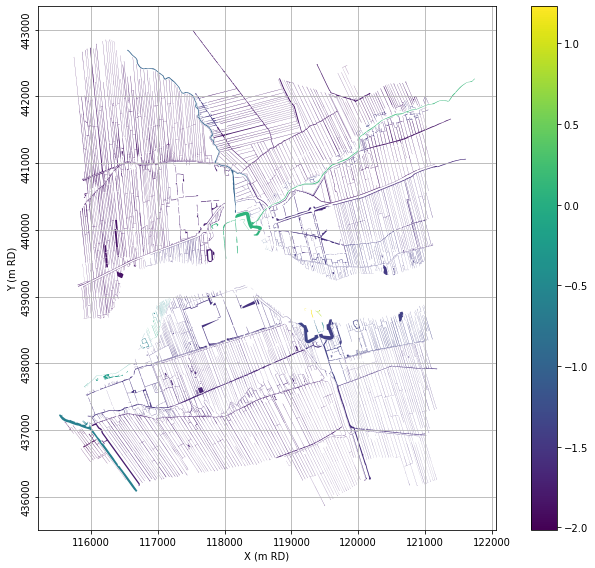

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw.plot(ax=ax, column="stage", legend=True)
ax.grid(b=True)
ax.set_xlabel("X (m RD)")
ax.set_ylabel("Y (m RD)")
plt.yticks(rotation=90, va="center")
fig.tight_layout()

## [Build model](#top)<a id='2'></a>

The next step is to define a model grid and build a model (i.e. create a discretization and define flow parameters). First we define the extent of our model and subsequently input that information into the convenient methods in `nlmod` to download all the relevant data and create a Modflow6 model. 

In [7]:
extent = [115900, 121000, 436600, 442000]  # Schoonhoven

Build the model. We're turning off a bunch of packages to keep the model as simple as possible.

In [8]:
model_ds, gwf = nlmod.create_model.gen_model_structured(
    'model2', 
    'schnhvn', 
    extent=extent, 
    delr=100.0,  # cellsize along rows
    delc=100.0,  # cellsize along columns
    use_cache=True,
    use_geotop=False,  # ignore GeoTOP for now (keep it simple)
    add_northsea=False,  
    add_recharge=False, 
    add_surface_drn=False, 
    add_surface_water_ghb=False,
    add_chd_edges=False,
)

## [Add surface water](#top)<a id='3'></a>

Now that we have a discretization (a grid, and layer tops and bottoms) we can start processing our surface water shapefile to add surface water features to our model. The method to add surface water starting from a shapefile is divided into the following steps:

1. Intersect surface water shape with grid. This steps intersects every feature with the grid so we can determine the surface water features in each cell.
2. Aggregate parameters per grid cell. Each feature within a cell has its own parameters. For MODFLOW it is often desirable to have one representative set of parameters per cell. These representative parameters are calculated in this step.
3. Build stress period data. The results from the previous step are converted to stress period data (generally a list of cellids and representative parameters: `[(cellid), parameters]`) which is used by MODFLOW and flopy to define boundary conditions.
4. Create the Modflow6 package

The steps are illustrated below.

### [Intersect surface water shape with grid](#top)<a id='3.1'></a>

The first step is to intersect the surface water shapefile with the grid.

In [9]:
sfw_grid = nlmod.surface_water.gdf2grid(sfw, gwf)

Intersecting with grid: 100%|██████████| 3883/3883 [00:11<00:00, 341.20it/s]


Plot the result and the model grid and color using `cellid`. It's hard to see but each feature is cut by the gridlines. 

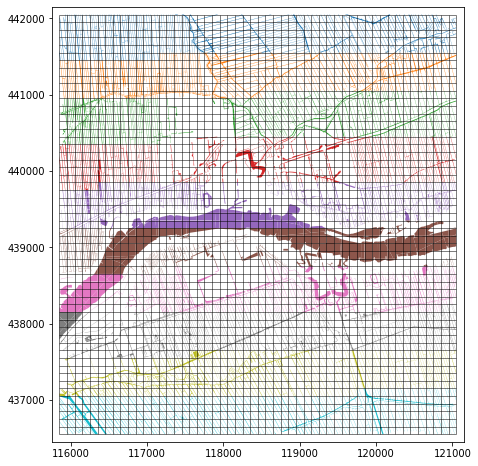

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_aspect("equal", adjustable="box")
sfw_grid.plot(ax=ax, column="cellid")
gwf.modelgrid.plot(ax=ax, linewidth=0.5, color="k")
xmin, xmax, ymin, ymax = extent
offset = 100
ax.set_xlim(xmin-offset, xmax+offset)
ax.set_ylim(ymin-offset, ymax+offset);

### [Aggregate parameters per model cell](#top)<a id='3.2'></a>

The next step is to aggregate the parameters for all the features in one grid cell to obtain one representative set of parameters. First, let's take a look at a grid cell containing multiple features.

In [11]:
# cid = (107, 6)  # for 50 x 50 m grid
cid = (5, 45)  # for 100 x 100 m grid
mask = sfw_grid.cellid == cid
sfw_grid.loc[mask]

,unique_id,peilvak_id,zp,wp,stage,botm,geometry,cellid
3727,NL.14.H041837,NL.14.PG0018,-1.77,-1.87,-1.82,-2.47,"POLYGON ((120380.350 441462.570, 120380.480 44...","(5, 45)"
3810,NL.14.H042409,NL.14.PG0957,-1.60,-1.60,-1.60,-2.20,"POLYGON ((120350.000 441470.724, 120350.570 44...","(5, 45)"
3863,NL.14.H042122,NL.14.PG0018,-1.77,-1.87,-1.82,-2.47,"POLYGON ((120436.235 441450.000, 120436.150 44...","(5, 45)"


We can also plot the features within that grid cell.

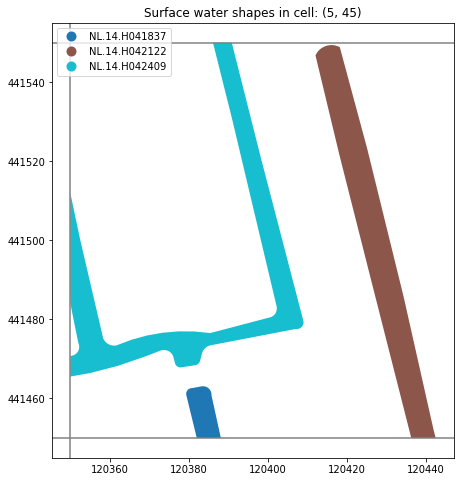

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sfw_grid.loc[mask].plot(column="unique_id", legend=True, ax=ax, 
                        legend_kwds={"loc":"upper left"})
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gwf.modelgrid.plot(ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title(f"Surface water shapes in cell: {cid}");

Now we want to aggregate the features in each cell to obtain a representative set of parameters (`stage`, `conductance`, `bottom elevation`) to use in the model. There are several aggregation methods. Note that the names of the methods are not representative of the aggregation applied to each parameter. For a full description see the following list:

- `'area_weighted'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is equal to area of surface water divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'max_area'`
  - **stage**: stage is determined by the largest surface water feature in a cell
  - **cond**: conductance is equal to area of all surface water features divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'de_lange'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is calculated using the formulas derived by De Lange (1999).
  - **elev**: the lowest bottom elevation is representative for the cell
  
Let's try using `area_weighted`. This means the stage is the area-weighted average of all the surface water features in a cell. The conductance is calculated by dividing the total area of surface water in a cell by the bottom resistance (`c0`). The representative bottom elevation is the lowest elevation present in the cell.

In [13]:
try:
    nlmod.surface_water.aggregate_surface_water(sfw_grid, "area_weighted")
except ValueError as e:
    print(e)

Missing columns in DataFrame: {'c0'}


The function checks whether the requisite columns are defined in the DataFrame. We need to add a column containing the bottom resistance `c0`. Often a value of 1 day is used as an initial estimate.

In [14]:
sfw_grid["c0"] = 1.0  # days

Now aggregate the features.

In [15]:
celldata = nlmod.surface_water.aggregate_surface_water(sfw_grid, "area_weighted")

Aggregate surface water data: 100%|██████████| 2730/2730 [00:09<00:00, 275.98it/s]


Let's take a look at the result. We now have a DataFrame with cell-id as the index and the three parameters we need for each cell `stage`, `cond` and `rbot`. The area is also given, but is not needed for the groundwater model. 

In [16]:
celldata.head(10)

stage         cond  rbot         area
0 0  -1.85  1133.709078 -2.15  1133.709078
  1  -1.85   867.381872 -2.85   867.381872
  2  -1.85  1548.403318 -2.85  1548.403318
  3  -1.85   900.756337 -2.15   900.756337
  4  -1.85   952.586453 -2.15   952.586453
  5  -1.85  1251.586935 -2.15  1251.586935
  6  -1.85  1534.221221 -2.15  1534.221221
  7  -1.85  1841.437581 -2.15  1841.437581
  8  -1.85  1487.595552 -2.15  1487.595552
  9  -1.85  1498.708284 -2.15  1498.708284

### [Build stress period data](#top)<a id='3.3'></a>

The next step is to take our cell-data and build convert it to 'stress period data' for MODFLOW. This is a data format that defines the parameters in each cell in the following format:

```
[[(cellid1), param1a, param1b, param1c],
 [(cellid2), param2a, param2b, param2c],
 ...]
```

The required parameters are defined by the MODFLOW-package used:

- **RIV**: for the river package `(stage, cond, rbot)`
- **DRN**: for the drain package `(stage, cond)`
- **GHB**: for the general-head-boundary package `(stage, cond)`

We're selecting the RIV package:

In [17]:
riv_spd = nlmod.surface_water.build_spd(celldata, "RIV", model_ds)

Building stress period data RIV:: 100%|██████████| 2730/2730 [00:09<00:00, 295.01it/s]


Take a look at the stress period data for the river package:

In [18]:
riv_spd[:10]

[[(1, 0, 0), -1.8500000000000003, 1133.7090784383768, -2.15],
 [(1, 0, 1), -1.8500000000000003, 867.3818719433158, -2.85],
 [(1, 0, 2), -1.85, 1548.4033184832308, -2.85],
 [(1, 0, 3), -1.85, 900.7563374228328, -2.15],
 [(1, 0, 4), -1.8500000000000003, 952.5864529821683, -2.15],
 [(1, 0, 5), -1.8499999999999999, 1251.5869347049272, -2.15],
 [(1, 0, 6), -1.85, 1534.2212206655145, -2.15],
 [(1, 0, 7), -1.8500000000000003, 1841.4375808423429, -2.15],
 [(1, 0, 8), -1.85, 1487.5955519055847, -2.15],
 [(1, 0, 9), -1.8500000000000003, 1498.7082841626495, -2.15]]

### [Create RIV package](#top)<a id='3.4'></a>

The final step is to create the river package using flopy.

In [19]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

Plot the river boundary condition to see where rivers were added in the model

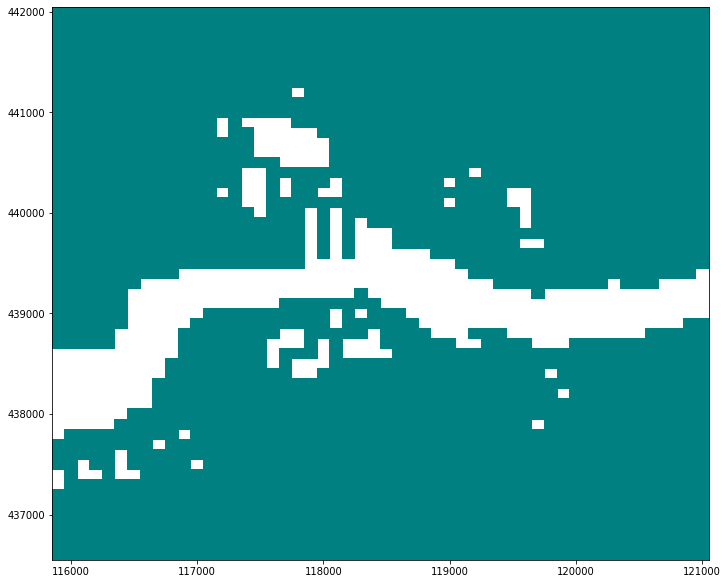

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1)
mv.plot_bc("RIV");

## [Write + run model](#top)<a id='4'></a>

Now write the model simulation to disk, and run the simulation.

In [21]:
gwf.simulation.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model schnhvn...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 2443 based on size of stress_period_data


In [22]:
gwf.simulation.run_simulation()

FloPy is using the following  executable to run the model: /home/david/usgs/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

  MODFLOW 6 compiled Oct 26 2020 14:20:06 with GFORTRAN compiler (ver. 9.3.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resour

(True, [])

## [Visualize results](#top)<a id='5'></a>

To see whether our surface water was correctly added to the model, let's visualize the results. We'll load the calculated heads, and plot them.

In [23]:
hds_obj = flopy.utils.HeadFile(os.path.join(model_ds.model_ws, model_ds.model_name) + ".hds")

Load the data, and set NODATA (often values of +1e30) to `np.nan`.

In [24]:
h = hds_obj.get_alldata()
h[h > 1e20] = np.nan  # set NODATA to NaN

Plot the heads in a specific model layer

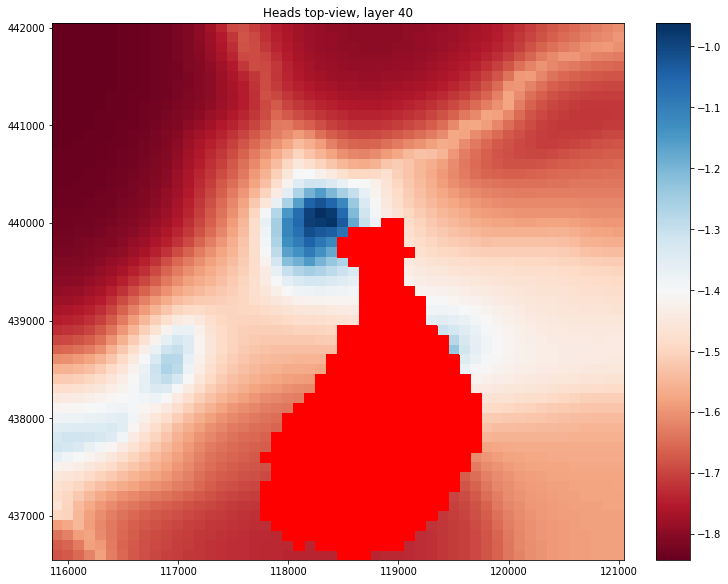

In [25]:
ilay = 40
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=ilay)
qm = mv.plot_array(h[-1], cmap="RdBu")  # last timestep
mv.plot_ibound()  # plot inactive cells in red
fig.colorbar(qm, shrink=1.0)
ax.set_title(f"Heads top-view, layer {ilay}");

In cross-section

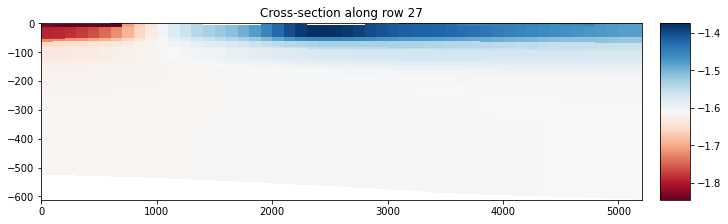

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True)
xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": gwf.modelgrid.nrow // 2})
qm = xs.plot_array(h[-1], cmap="RdBu")  # last timestep
xs.plot_ibound()  # plot inactive cells in red
fig.colorbar(qm, shrink=1.0);
ax.set_title(f"Cross-section along row {gwf.modelgrid.nrow // 2}");